In [93]:
# Griffin Davis, The University of Texas at Dallas
# (C) 2022
# Data source:
# Chetty, Raj; Friedman, John; Hendren, Nathaniel; Jones, Maggie R.; Porter, Sonya R., 2022, 
# "Replication Data for: The Opportunity Atlas: Mapping the Childhood Roots of Social Mobility", 
# https://doi.org/10.7910/DVN/NKCQM1, Harvard Dataverse, V1, UNF:6:wwWmCZy1LUqtq02qHdCKFQ== [fileUNF] 

import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

# Download data
!wget -nc https://personal.utdallas.edu/~gcd/data/tract_merged.csv
ds = pd.read_csv('tract_merged.csv')

File ‘tract_merged.csv’ already there; not retrieving.



In [2]:
def eval_metrics(actual, pred):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return mse, rmse, mae, r2

In [83]:
# Get subset of columns
cols = ['id', 'hhinc_mean2000', 'mean_commutetime2000', 'frac_coll_plus2000', 'frac_coll_plus2010', 
        'med_hhinc1990', 'med_hhinc2016', 'popdensity2000', 'poor_share2010', 'poor_share2000', 
        'poor_share1990', 'gsmn_math_g3_2013', 'traveltime15_2010', 'emp2000', 'singleparent_share1990',
        'singleparent_share2010', 'singleparent_share2000', 
        'mail_return_rate2010', 'jobs_total_5mi_2015', 'jobs_highpay_5mi_2015', 
        'popdensity2010', 'job_density_2013', 'kfr_pooled_pooled_p1', 
        'kfr_pooled_pooled_p25', 'kfr_pooled_pooled_p50', 'kfr_pooled_pooled_p75', 'kfr_pooled_pooled_p100']

features = cols[1:-5]

exluded = ['rent_twobed2015', 'ln_wage_growth_hs_grad', 'ann_avg_job_growth_2004_2013']

# Handle null data
ds = ds[ds.columns[ds.columns.isin(cols)]]
ds = ds.dropna()

In [84]:
# Shuffle split the data into training and test sets (75% / 25%)
train, test = train_test_split(ds)

train_X = train.loc[:,'hhinc_mean2000':'job_density_2013']
test_X = test.loc[:,'hhinc_mean2000':'job_density_2013']

In [64]:
tree_depth_rmse = []
tree_percentile_rmse = [[] for i in range(2, 11)]
tree_splits_d3 = [{} for i in range(0, 4)]

percentiles = ['kfr_pooled_pooled_p1', 'kfr_pooled_pooled_p25', 'kfr_pooled_pooled_p50', 'kfr_pooled_pooled_p75']

for quarter in range(0, 4):
    train_Y = train.loc[:, percentiles[quarter]]
    test_Y = test.loc[:, percentiles[quarter]]
    
    tree_depth_rmse_per = []
    for depth in range(2, 11):
        with mlflow.start_run():
            model = tree.DecisionTreeRegressor(max_depth=depth)
            model = model.fit(train_X, train_Y)

            predict_Y = model.predict(test_X)

            (mse, rmse, mae, r2) = eval_metrics(test_Y, predict_Y)
            
            tree_depth_rmse_per.append(rmse)
            
            tree_percentile_rmse[depth-2].append(rmse)

            if depth == 3:
                # Store information about feature splits
                num_nodes = model.tree_.node_count
                children_left = model.tree_.children_left
                children_right = model.tree_.children_right
                feature = model.tree_.feature

                stack = [(0, 0)]
                while len(stack) > 0:
                    node_id, depth = stack.pop()

                    is_split_node = children_left[node_id] != children_right[node_id]
                    if is_split_node:
                        feat = feature[node_id]
                        if feat in tree_splits_d3[quarter]:
                            tree_splits_d3[quarter][feat] = tree_splits_d3[quarter][feat]+1
                        else:
                            tree_splits_d3[quarter][feat] = 1
                        stack.append((children_left[node_id], depth+1))
                        stack.append((children_right[node_id], depth+1))

            mlflow.log_param("parent", percentiles[quarter])
            mlflow.log_param("depth", depth)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae", mae)

            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(model, "model", registered_model_name="DecisionTree")
            else:
                mlflow.sklearn.log_model(model, "model")
            
    tree_depth_rmse.append(tree_depth_rmse_per)

In [65]:
# Replace feature indexes with labels in tree_splits_d5
label_tree_splits_d3 = [{} for i in range(4)]
for quarter in range(len(tree_splits_d3)):
    for feat_index in tree_splits_d3[quarter]:
            feat = features[feat_index]
            label_tree_splits_d3[quarter][feat] = tree_splits_d3[quarter][feat_index]

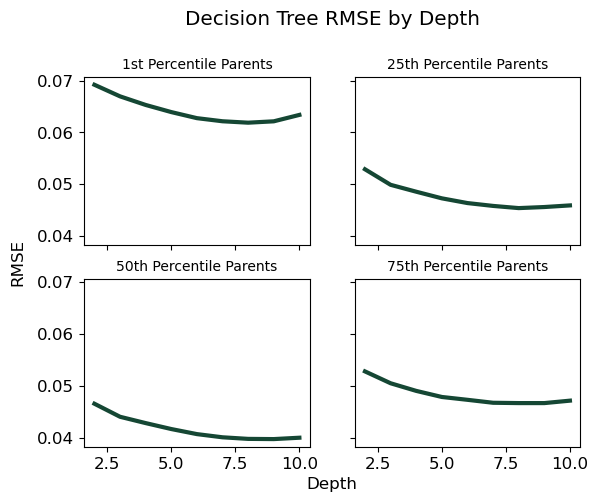

In [66]:
# Plot error versus depth
depths = [ i for i in range(2, 11) ]
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
fig.add_subplot(111, frameon=False)
axes[0, 0].plot(depths, tree_depth_rmse[0], color="#154734", label="Root Mean Square Error", linewidth=3)
axes[0, 0].set_title('1st Percentile Parents', fontsize=10)
axes[0, 1].plot(depths, tree_depth_rmse[1], color="#154734", label="Root Mean Square Error", linewidth=3)
axes[0, 1].set_title('25th Percentile Parents', fontsize=10)
axes[1, 0].plot(depths, tree_depth_rmse[2], color="#154734", label="Root Mean Square Error", linewidth=3)
axes[1, 0].set_title('50th Percentile Parents', fontsize=10)
axes[1, 1].plot(depths, tree_depth_rmse[3], color="#154734", label="Root Mean Square Error", linewidth=3)
axes[1, 1].set_title('75th Percentile Parents', fontsize=10)
plt.rc('font', size=12)  
plt.title('Decision Tree RMSE by Depth\n\n')
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Depth', fontsize=12)
plt.ylabel('RMSE\n', fontsize=12)
plt.show()

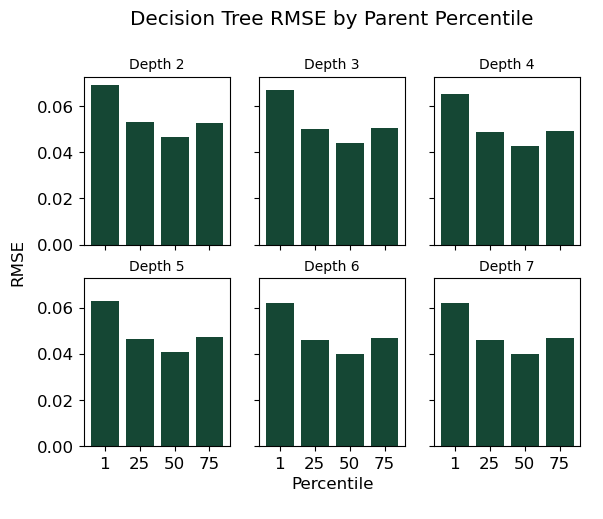

In [67]:
# Plot error versus parent percentile
percentile_labels = ['1', '25', '50', '75']
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)
fig.add_subplot(111, frameon=False)
axes[0, 0].bar(percentile_labels, tree_percentile_rmse[0], color="#154734", label="Root Mean Square Error", linewidth=3)
axes[0, 0].set_title('Depth 2', fontsize=10)
axes[0, 1].bar(percentile_labels, tree_percentile_rmse[1], color="#154734", label="Root Mean Square Error", linewidth=3)
axes[0, 1].set_title('Depth 3', fontsize=10)
axes[0, 2].bar(percentile_labels, tree_percentile_rmse[2], color="#154734", label="Root Mean Square Error", linewidth=3)
axes[0, 2].set_title('Depth 4', fontsize=10)
axes[1, 0].bar(percentile_labels, tree_percentile_rmse[4], color="#154734", label="Root Mean Square Error", linewidth=3)
axes[1, 0].set_title('Depth 5', fontsize=10)
axes[1, 1].bar(percentile_labels, tree_percentile_rmse[5], color="#154734", label="Root Mean Square Error", linewidth=3)
axes[1, 1].set_title('Depth 6', fontsize=10)
axes[1, 2].bar(percentile_labels, tree_percentile_rmse[5], color="#154734", label="Root Mean Square Error", linewidth=3)
axes[1, 2].set_title('Depth 7', fontsize=10)
plt.rc('font', size=12)
plt.title('Decision Tree RMSE by Parent Percentile\n\n')
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Percentile\n', fontsize=12)
plt.ylabel('RMSE\n', fontsize=12)
plt.show()

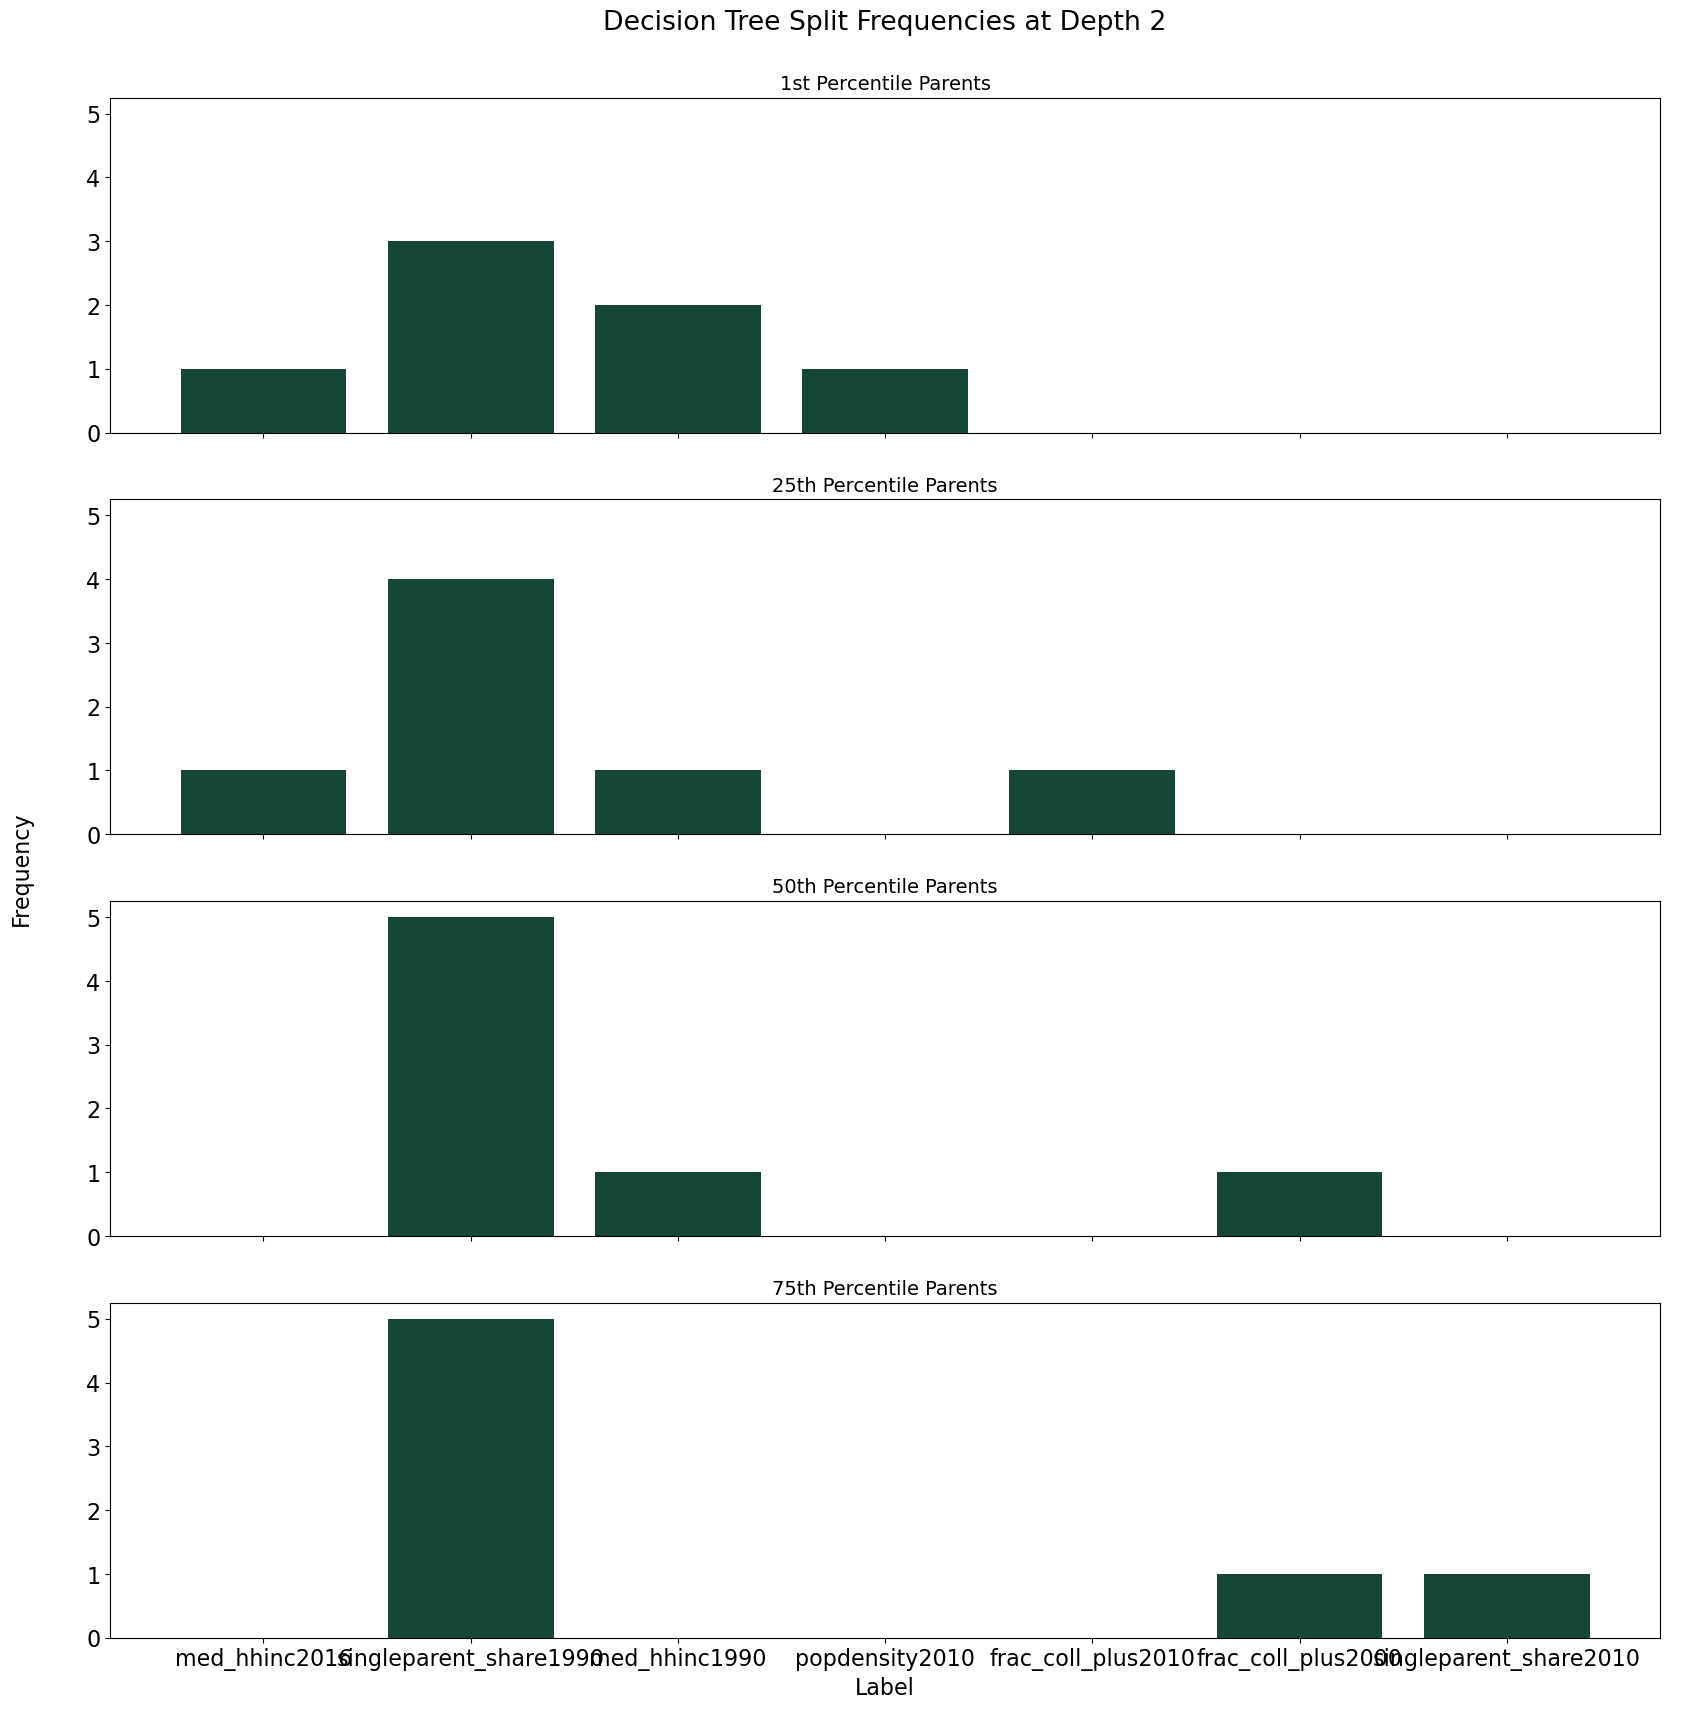

In [73]:
# Plot feature histogram by 
depths = [ i for i in range(2, 11) ]
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True)
fig.add_subplot(111, frameon=False)
fig.set_size_inches(20, 20)
axes[0].bar(list(label_tree_splits_d3[0].keys()), label_tree_splits_d3[0].values(), color="#154734")
axes[0].set_title('1st Percentile Parents', fontsize=14)
axes[1].bar(list(label_tree_splits_d3[1].keys()), label_tree_splits_d3[1].values(), color="#154734")
axes[1].set_title('25th Percentile Parents', fontsize=14)
axes[2].bar(list(label_tree_splits_d3[2].keys()), label_tree_splits_d3[2].values(), color="#154734")
axes[2].set_title('50th Percentile Parents', fontsize=14)
axes[3].bar(list(label_tree_splits_d3[3].keys()), label_tree_splits_d3[3].values(), color="#154734")
axes[3].set_title('75th Percentile Parents', fontsize=14)
plt.rc('font', size=16)  
plt.title('Decision Tree Split Frequencies at Depth 2\n\n')
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Label', fontsize=16)
plt.ylabel('Frequency\n', fontsize=16)
plt.show()

[Text(0.5, 0.8333333333333334, 'X[13] <= 0.32\nsquared_error = 0.005\nsamples = 53177\nvalue = 0.429'),
 Text(0.25, 0.5, 'X[13] <= 0.179\nsquared_error = 0.004\nsamples = 35228\nvalue = 0.456'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.004\nsamples = 12717\nvalue = 0.489'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.003\nsamples = 22511\nvalue = 0.437'),
 Text(0.75, 0.5, 'X[13] <= 0.533\nsquared_error = 0.003\nsamples = 17949\nvalue = 0.375'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.002\nsamples = 13249\nvalue = 0.393'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.002\nsamples = 4700\nvalue = 0.326')]

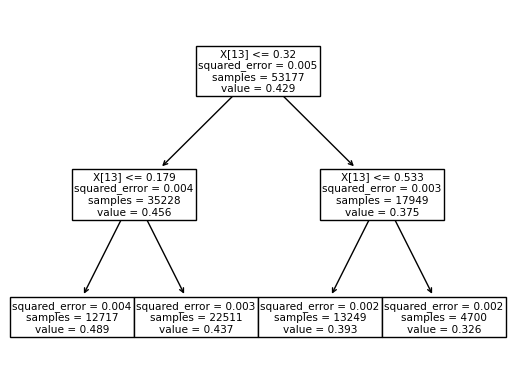

In [85]:
train_Y = train.loc[:, percentiles[1]]
model = tree.DecisionTreeRegressor(max_depth=2)
model = model.fit(train_X, train_Y)
tree.plot_tree(model)

0.02341041057461099


[Text(0.5, 0.8333333333333334, 'X[5] <= 6996.5\nsquared_error = 0.024\nsamples = 53177\nvalue = 0.229'),
 Text(0.25, 0.5, 'X[1] <= 26.663\nsquared_error = 0.043\nsamples = 6\nvalue = 0.517'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.016\nsamples = 3\nvalue = 0.334'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.004\nsamples = 3\nvalue = 0.7'),
 Text(0.75, 0.5, 'X[13] <= 69.45\nsquared_error = 0.024\nsamples = 53171\nvalue = 0.229'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.026\nsamples = 5675\nvalue = 0.237'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.024\nsamples = 47496\nvalue = 0.229')]

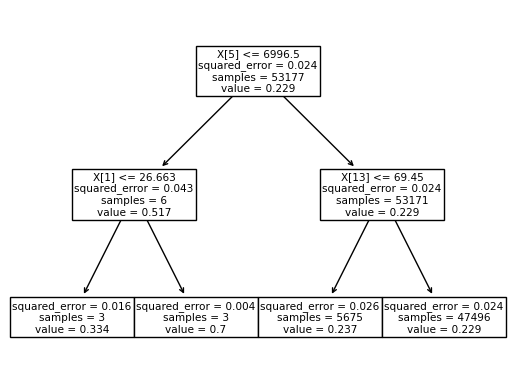

In [79]:
# Build trees to predict singleparent_share1990
Y = ds['singleparent_share1990']

# Get subset of columns
features = ['hhinc_mean2000', 'mean_commutetime2000', 'frac_coll_plus2000', 'frac_coll_plus2010', 
        'med_hhinc1990', 'med_hhinc2016', 'popdensity2000', 'poor_share2010', 'poor_share2000', 
        'poor_share1990', 'gsmn_math_g3_2013', 'traveltime15_2010', 'emp2000', 
        'mail_return_rate2010', 'jobs_total_5mi_2015', 'jobs_highpay_5mi_2015', 
        'popdensity2010', 'job_density_2013']
    
excluded = ['singleparent_share2010', 'singleparent_share2000']

X = ds[ds.columns[ds.columns.isin(cols)]]
X = X.dropna()

# Shuffle split the data into training and test sets (75% / 25%)
train_X, test_X = train_test_split(X)
train_Y, test_Y = train_test_split(Y)

model = tree.DecisionTreeRegressor(max_depth=2)
model = model.fit(train_X, train_Y)

predict_Y = model.predict(test_X)

(mse, rmse, mae, r2) = eval_metrics(test_Y, predict_Y)

print(mse)
tree.plot_tree(model)

In [80]:
print(features[5])
print(features[1])
print(features[13])

med_hhinc2016
mean_commutetime2000
mail_return_rate2010
